In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.getcwd(), "trainlogs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
COCO_MODEL_PATH = os.path.join(os.getcwd(), "logs/coco20191016T1657/mask_rcnn_coco_0150.h5")

Using TensorFlow backend.


In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "datasets/coco"  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 213

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                226
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Build validation dataset
if config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=2.85s)
creating index...
index created!
Images: 12964
Classes: ['BG', '/m/012n7d', '/m/0138tl', '/m/014j1m', '/m/015p6', '/m/015qff', '/m/015wgc', '/m/015x4r', '/m/015x5n', '/m/0162_1', '/m/016m2d', '/m/0174k2', '/m/0174n1', '/m/0176mf', '/m/018xm', '/m/019w40', '/m/01_5g', '/m/01b638', '/m/01b9xk', '/m/01bfm9', '/m/01bjv', '/m/01bms0', '/m/01bqk0', '/m/01btn', '/m/01c648', '/m/01d40f', '/m/01dwsz', '/m/01dwwc', '/m/01f91_', '/m/01fb_0', '/m/01fh4r', '/m/01g317', '/m/01gkx_', '/m/01h44', '/m/01h8tj', '/m/01j3zr', '/m/01j5ks', '/m/01jfm_', '/m/01k6s3', '/m/01kb5b', '/m/01lrl', '/m/01lsmm', '/m/01m2v', '/m/01m4t', '/m/01mqdt', '/m/01n4qj', '/m/01nq26', '/m/01pns0', '/m/01rkbr', '/m/01tcjp', '/m/01x3jk', '/m/01x3z', '/m/01x_v', '/m/01xq0k1', '/m/01xqw', '/m/01xs3r', '/m/01xyhv', '/m/020lf', '/m/021mn', '/m/0242l', '/m/025dyy', '/m/025nd', '/m/026qbn5', '/m/0271t', '/m/0283dt1', '/m/029bxz', '/m/02crq1', '/m/02cvgx', '/m/02d1br', '/m/02d9qx', '/m/

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

W1128 16:54:35.455536 140534652941696 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:504: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1128 16:54:35.497140 140534652941696 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1128 16:54:35.539345 140534652941696 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3828: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1128 16:54:35.628592 140534652941696 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3652: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1128 16:54:39.479317 140534652941696 d

Loading weights  /home/jupyter/Segmentation/Mask_RCNN/logs/coco20191016T1657/mask_rcnn_coco_0150.h5
Re-starting from epoch 150


In [8]:
from pathlib import Path
import pandas as pd
def get_string_to_name():
    csv_path = Path("__file__").parent.joinpath("datasets", "challenge-2019-classes-description-segmentable.csv")
    df = pd.read_csv(str(csv_path), header=None, names=["class_string", "class_name"])
    class_string_to_name = dict(zip(df.class_string,df.class_name))
    return class_string_to_name

In [9]:
string_to_name = get_string_to_name()

In [10]:
classes = ["BG"] 
for i in dataset.class_names:
    if i != "BG":
        classes.append(string_to_name[i])

In [11]:
DATA_DIR = "datasets/coco/train2017"
file_names = next(os.walk(DATA_DIR))[2]

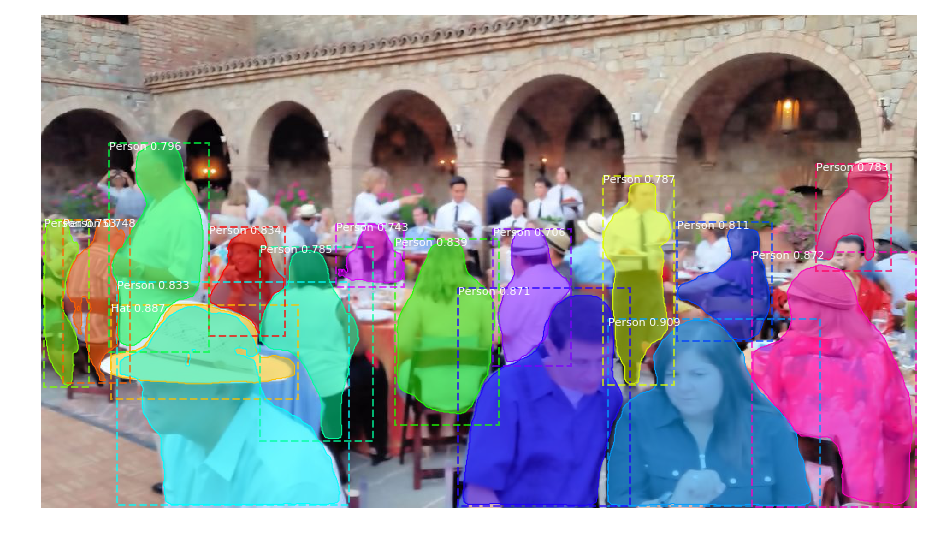

In [13]:
import random
import skimage.io
# Load a random image from the images folder
#file_names = next(os.walk(DATA_DIR))[2]
#print(file_names)
image = skimage.io.imread(os.path.join(DATA_DIR, random.choice(file_names)))
# image = skimage.io.imread(os.path.join(DATA_DIR, file_names[291]))

# Run detection
results = model.detect([image])

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            classes, r['scores'])

In [114]:
classes = ["Person, Men", "Person", "Person, Boy", "Trousers, Jeans"]

In [97]:
r["class_ids"]

array([ 31,  31, 151,  31,  31,  31,  31], dtype=int32)

In [113]:
r["scores"]

array([0.9553404 , 0.9417061 , 0.9406108 , 0.928236  , 0.92580295,
       0.8528743 , 0.8229366 ], dtype=float32)

In [123]:
from numpy import array
r["class_ids"] = array([2,1,3,1,0,1,0])

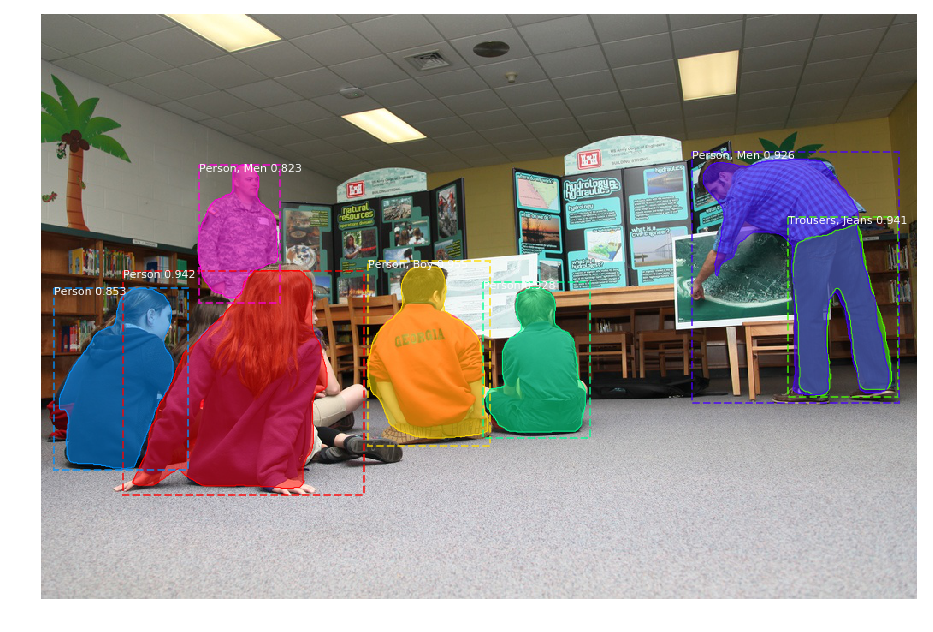

In [124]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            classes, r['scores'])

image ID: coco.7235 (7234) http://cocodataset.org/#explore?id=7235
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 226)              min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


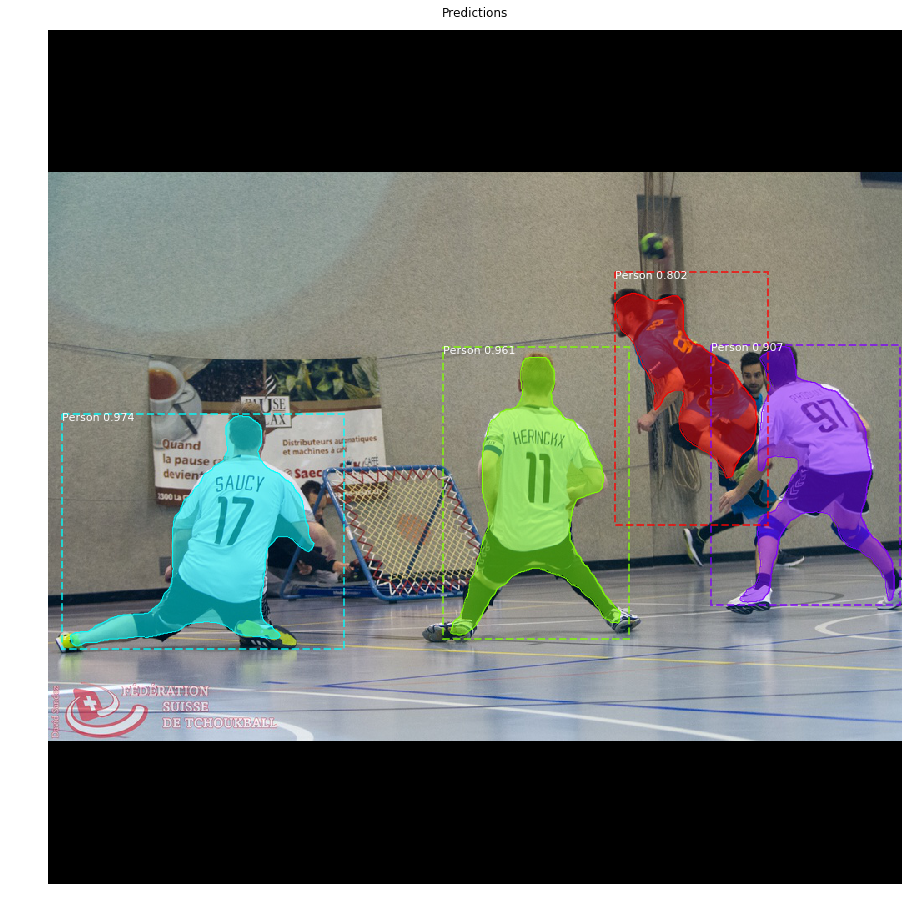

gt_class_id              shape: (5,)                  min:   31.00000  max:   31.00000  int32
gt_bbox                  shape: (5, 4)                min:  247.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


In [36]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            classes, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [13]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str


In [14]:
from tqdm import tqdm

In [15]:
empty_submission_df = pd.read_csv("sample_empty_submission.csv")

In [16]:
class_lookup_df = pd.read_csv("challenge-2019-classes-description-segmentable.csv", header=None)

In [17]:
# we have to convert coco classes to this competition's one.

class_lookup_df.columns = ["encoded_label","label"]
# class_lookup_df['label'] = class_lookup_df['label']
class_lookup_df.head()

,encoded_label,label
0,/m/01bms0,Screwdriver
1,/m/03jbxj,Light switch
2,/m/0jy4k,Doughnut
3,/m/09gtd,Toilet paper
4,/m/01j5ks,Wrench


In [18]:
class_lookup_df[class_lookup_df["label"] == "Screwdriver"]

,encoded_label,label
0,/m/01bms0,Screwdriver


In [ ]:
ImageID_list = []
ImageWidth_list = []
ImageHeight_list = []
PredictionString_list = []

for num, row in tqdm(empty_submission_df.iterrows(), total=len(empty_submission_df)):
    filename = row["ImageID"] + ".jpg"
   
    image = skimage.io.imread(os.path.join("datasets/test", filename))
    results = model.detect([image])
    r = results[0]
    
    height = image.shape[0]
    width  = image.shape[1]
        
    PredictionString = ""
    
    for i in range(len(r["class_ids"])):        
        class_id = r["class_ids"][i]
        roi = r["rois"][i]
        mask = r["masks"][:,:,i]
        confidence = r["scores"][i]
        
        encoded_mask = encode_binary_mask(mask)
        
        labelname = classes[r['class_ids'][i]]
        if class_lookup_df[class_lookup_df["label"] == labelname].shape[0] == 0:
            # no match label
            continue
        
        encoded_label = class_lookup_df[class_lookup_df["label"] == labelname]["encoded_label"].item()

        PredictionString += encoded_label 
        PredictionString += " "
        PredictionString += str(confidence)
        PredictionString += " "
        PredictionString += encoded_mask.decode()
        PredictionString += " "
        
    ImageID_list.append(row["ImageID"])
    ImageWidth_list.append(width)
    ImageHeight_list.append(height)
    PredictionString_list.append(PredictionString)

 63%|██████▎   | 62716/99999 [7:27:47<4:33:04,  2.28it/s]

In [ ]:
results=pd.DataFrame({"ImageID":ImageID_list,
                      "ImageWidth":ImageWidth_list,
                      "ImageHeight":ImageHeight_list,
                      "PredictionString":PredictionString_list
                     })

In [ ]:
results.to_csv("submissionL0.csv", index=False)

In [2]:
import pandas as pd
df = pd.read_csv("submissionL0.csv")
df.tail()

,ImageID,ImageWidth,ImageHeight,PredictionString
99994,e40f388b3a4f80a6,1024,576,/m/0138tl 0.9478371 eNqVUtFuwyAM/CXjEMiiqNKmrE...
99995,a21b4cd415d83b4d,1024,767,/m/079cl 0.9034182 eNo1jMEKwkAMRH9pkl09FYsKHkq...
99996,750b5d6e41c23bc9,961,768,/m/01xyhv 0.9799627 eNpdU+t22jAMfiXJuTnL2nNGCw...
99997,4944489aca12f92e,1024,678,/m/01mqdt 0.9558635 eNoLzgm3CzAMTTEw8jXxNfI19j...
99998,632dad5b912b4b6a,1022,768,/m/06z37_ 0.73817486 eNrLCAqxMgpNN0g0DIn0j/fzM...


In [3]:
import pandas as pd
df = pd.read_csv("submissionL1.csv")
df.tail()

,ImageID,ImageWidth,ImageHeight,PredictionString
99994,e40f388b3a4f80a6,1024,576,NaN
99995,a21b4cd415d83b4d,1024,767,NaN
99996,750b5d6e41c23bc9,961,768,/m/04yx4 0.93965673 eNplU+uWojAMfqUAkgC6e86uCi...
99997,4944489aca12f92e,1024,678,NaN
99998,632dad5b912b4b6a,1022,768,/m/0h8my_4 0.81716484 eNotiMEKgCAQRH9pd7UgqFsQ...


In [4]:
import pandas as pd
df = pd.read_csv("integrated_result.csv")
df.tail()

,ImageID,ImageWidth,ImageHeight,PredictionString
99994,fffd297f235ca68b,1024,768,/m/0k4j 0.97400516 eNp1UNEKwjAM/KUkswjzxTcR14Q...
99995,fffe6ce981457e6e,1024,444,/m/01g317 0.78394485 eNptT00LwjAM/Uttk25zsIsHV...
99996,fffec786d733bbcb,1024,768,/m/01g317 0.96026117 eNplUk1PwzAM/Uv+aDkAVziss...
99997,ffffea14c148f6d0,1023,768,NaN
99998,fffffefca02f6806,1024,768,NaN
